<a href="https://colab.research.google.com/github/posilash/floorgan/blob/main/floorgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# # plan dataset

# !gdown 1eoEpmQDlfDvx8xhVIlf05ahl6efVPVVk
# !unzip plan.zip
# !mkdir data1
# !mv plan data1/
# !mkdir model

In [ ]:
# !gdown 1A-QjkY3CeiusQXQ2s7pH-90Jaj_cmBP8
# !unzip floorplan_dataset.zip
# !mkdir data
# !mv floorplan_datadet data/floorplan_dataset


In [ ]:
!pip install torchmetrics
!pip install torchmetrics[image]

In [ ]:
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.distributed as dist
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
import torchvision.models as models
from torchvision.models import inception_v3
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from scipy.linalg import sqrtm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.inception import InceptionScore
from torchmetrics.image import StructuralSimilarityIndexMeasure
from torchmetrics.image import PeakSignalNoiseRatio

# # Set random seed for reproducibility
# manualSeed = 9969
# #manualSeed = random.randint(1, 10000) # use if you want new results
# print("Random Seed: ", manualSeed)
# random.seed(manualSeed)
# torch.manual_seed(manualSeed)
# torch.use_deterministic_algorithms(True) # Needed for reproducible results

ModuleNotFoundError: No module named 'torchmetrics'

In [ ]:
################################
# Declaring the hyperparameters
################################

# Root directory for dataset
dataroot = "/content/data1/"
# Number of workers for dataloader
workers = 13
# Batch size during training
batch_size = 128
# preferred image size using a transformer
image_size = 128
# Number of channels in the training images
nc = 3
# Size of z latent vector
nz = 100
# Size of feature maps in generator
ngf = 64
# Size of feature maps in discriminator
ndf = 64
# Number of training epochs
num_epochs = 600
# Learning rate
lr = 0.0002
# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5
# Number of GPUs available
ngpu = 1

In [ ]:
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.RandomRotation(10),
                               transforms.RandomHorizontalFlip(),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers, pin_memory=True, drop_last=True)

# Set Pytorch to use GPU
device = torch.device("cuda")

# #Plot some training images
# real_batch = next(iter(dataloader))
# plt.figure(figsize=(8,8))
# plt.axis("off")
# plt.title("Training Images")
# plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
# plt.show()

In [ ]:
# # custom weights initialization called on ``netG`` and ``netD``
# def weights_init(m):
#     classname = m.__class__.__name__
#     if classname.find('Conv') != -1:
#         nn.init.normal_(m.weight.data, 0.0, 0.02)
#     elif classname.find('BatchNorm') != -1:
#         nn.init.normal_(m.weight.data, 1.0, 0.02)
#         nn.init.constant_(m.bias.data, 0)


In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.xavier_normal_(m.weight.data, gain=0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
# @title 64 G

# # Generator Code

# class Generator(nn.Module):
#     def __init__(self, ngpu):
#         super(Generator, self).__init__()
#         self.ngpu = ngpu
#         self.main = nn.Sequential(
#             # input is Z, going into a convolution
#             nn.ConvTranspose2d( nz, ngf * 8, kernel_size=4, stride=1, padding=0, bias=False),
#             nn.BatchNorm2d(ngf * 8),
#             nn.ReLU(True),
#             # state size. ``(ngf*8) x 4 x 4``
#             nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ngf * 4),
#             nn.ReLU(True),
#             # state size. ``(ngf*4) x 8 x 8``
#             nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ngf * 2),
#             nn.ReLU(True),
#             # state size. ``(ngf*2) x 16 x 16``
#             nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ngf),
#             nn.ReLU(True),
#             # state size. ``(ngf) x 32 x 32``
#             nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
#             nn.Tanh()
#             # state size. ``(nc) x 64 x 64``
#         )

#     def forward(self, input):
#         return self.main(input)

In [ ]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(     nz, ngf * 16, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 16),
            nn.ReLU(True),
            # state size. (ngf*16) x 4 x 4
            nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 8 x 8
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 16 x 16
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 32 x 32
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 64 x 64
            nn.ConvTranspose2d(    ngf,      nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 128 x 128
        )
    def forward(self, input):
        return self.main(input)

In [ ]:
# Create the generator
netG = Generator(ngpu).to(device)

# Initialize the weights
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): BatchN

Discriminator Code

In [ ]:
# @title 64 D

# class Discriminator(nn.Module):
#     def __init__(self, ngpu):
#         super(Discriminator, self).__init__()
#         self.ngpu = ngpu
#         self.main = nn.Sequential(
#             # input is ``(nc) x 64 x 64``
#             nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. ``(ndf) x 32 x 32``
#             nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ndf * 2),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. ``(ndf*2) x 16 x 16``
#             nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ndf * 4),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. ``(ndf*4) x 8 x 8``
#             nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ndf * 8),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. ``(ndf*8) x 4 x 4``
#             nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
#             nn.Sigmoid()
#         )

#     def forward(self, input):
#         return self.main(input)

In [ ]:
# @title 128 D
#128x128
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 128 x 128
            nn.Conv2d(nc, ndf, 4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 64 x 64
            nn.Conv2d(ndf, ndf * 2, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 32 x 32
            nn.Conv2d(ndf * 2, ndf * 4, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 16 x 16
            nn.Conv2d(ndf * 4, ndf * 8, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 8 x 8
            nn.Conv2d(ndf * 8, ndf * 16, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*16) x 4 x 4
            nn.Conv2d(ndf * 16, 1, 4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
            # state size. 1
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Initialize the weights
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): BatchNorm2d(1024, eps=1e-05

In [ ]:
# Initialize the BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both Generator and Discriminator
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
def save_generated_images(generator, noise, epoch, output_dir='generated_images', num_images=5):
    os.makedirs(output_dir, exist_ok=True)
    with torch.no_grad():
        generated = generator(noise).detach().cpu()
    grid = vutils.make_grid(generated[:num_images], padding=2, normalize=True)
    save_path = os.path.join(output_dir, f'generated_epoch_{epoch}.png')
    vutils.save_image(grid, save_path)

In [ ]:
# @title Default title text
# # Training Loop

# # Lists to keep track of the training progress
# img_list = []
# G_losses = []
# D_losses = []
# iters = 0

# print("Starting Training Loop...")
# # For each epoch
# for epoch in range(num_epochs):
#     # For each batch in the dataloader
#     for i, data in enumerate(dataloader, 0):

#         ############################
#         # Update Discriminator network
#         ###########################
#         ## Train with all real batch
#         netD.zero_grad()
#         # Format batch
#         real_cpu = data[0].to(device)
#         b_size = real_cpu.size(0)
#         label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
#         # Forward pass real batch through Discriminator
#         output = netD(real_cpu).view(-1)
#         # Calculate loss on all real batch
#         errD_real = criterion(output, label)
#         # Calculate gradients for Discriminator in backward pass
#         errD_real.backward()
#         D_x = output.mean().item()

#         ## Train with all fake batch
#         # Generate batch of latent vectors
#         noise = torch.randn(b_size, nz, 1, 1, device=device)
#         # Generate fake image batch with Generator
#         fake = netG(noise)
#         label.fill_(fake_label)
#         # Classify all fake batch with Discriminator
#         output = netD(fake.detach()).view(-1)
#         # Calculate the Discriminator loss on the all fake batch
#         errD_fake = criterion(output, label)
#         # Calculate the gradients for this batch, accumulated (summed) with previous gradients
#         errD_fake.backward()
#         D_G_z1 = output.mean().item()
#         # Compute error of Discriminator as sum over the fake and the real batches
#         errD = errD_real + errD_fake
#         # Update Discriminator
#         optimizerD.step()

#         ############################
#         # Update Generator network
#         ###########################
#         netG.zero_grad()
#         # fake labels are real for generator cost
#         label.fill_(real_label)
#         # Since the Discriminator just got updated, another forward-
#         # pass of all fake batch through Discriminator is performed
#         output = netD(fake).view(-1)
#         # Calculate Generators loss based on this output
#         errG = criterion(output, label)
#         # Calculate gradients for Generator
#         errG.backward()
#         D_G_z2 = output.mean().item()
#         # Update Generator
#         optimizerG.step()

#         # Output training statistics
#         if i % 50 == 0:
#             print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
#                   % (epoch, num_epochs, i, len(dataloader),
#                      errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

#         # Save Losses for plotting
#         G_losses.append(errG.item())
#         D_losses.append(errD.item())

#         # Check how the generator is doing by saving Generators output on fixed_noise
#         if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
#             with torch.no_grad():
#                 fake = netG(fixed_noise).detach().cpu()
#             img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

#         iters += 1

#     # Save the model through various epochs
#     if epoch % 2 == 0:
#         torch.save({
#             'generator' : netG.state_dict(),
#             'discriminator' : netD.state_dict(),
#             'optimizerG' : optimizerG.state_dict(),
#             'optimizerD' : optimizerD.state_dict(),
#             }, 'model/model_epoch_{}.pth'.format(epoch))

# # Save the final trained model.
# torch.save({
#             'generator' : netG.state_dict(),
#             'discriminator' : netD.state_dict(),
#             'optimizerG' : optimizerG.state_dict(),
#             'optimizerD' : optimizerD.state_dict(),
#             }, 'model/model_final.pth')

In [ ]:
# # Create FID metric
# fid = FrechetInceptionDistance(feature=192, reset_real_features=False).set_dtype(torch.float64)

# # Precompute activations for real images
# for real_images, _ in dataloader:
#     real_cpu = real_images.to('cpu')
#     fid.update(real_cpu.clamp(-1, 1).to(torch.uint8), real=True)

# # Get and store precomputed real activations
# precomputed_real_activations = fid.real_features
# torch.save(precomputed_real_activations, "precomputed_real_activations.pt")

In [ ]:
# Training Loop

# Lists to keep track of the training progress
img_list = []
G_losses = []
D_losses = []
iters = 0

# Initialize lists to store evaluation metrics
is_scores = []
# fid_scores = []
# ssim_scores = []
psnr_scores = []

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # Update Discriminator network
        ###########################
        ## Train with all real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through Discriminator
        output = netD(real_cpu).view(-1)
        # Calculate loss on all real batch
        errD_real = criterion(output, label)
        # Calculate gradients for Discriminator in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with Generator
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with Discriminator
        output = netD(fake.detach()).view(-1)
        # Calculate the Discriminator loss on the all fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of Discriminator as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update Discriminator
        optimizerD.step()

        ############################
        # Update Generator network
        ###########################
        netG.zero_grad()
        # fake labels are real for generator cost
        label.fill_(real_label)
        # Since the Discriminator just got updated, another forward-
        # pass of all fake batch through Discriminator is performed
        output = netD(fake).view(-1)
        # Calculate Generators loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for Generator
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update Generator
        optimizerG.step()

        # Output training statistics
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save generated images every 5 epochs
        if epoch % 5 == 0 and i == len(dataloader)-1:
            save_generated_images(netG, fixed_noise, epoch)

        # Save Losses for plotting
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving Generators output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        if epoch % 5 == 0 and i == len(dataloader)-1:
                #######################
                # Evaluation Metrics
                #######################
                gen_imgs = fake.clamp(-1, 1).to('cpu')
                real_imgs = real_cpu.clamp(-1, 1).to('cpu')

                # Inception Score
                inception = InceptionScore()
                # generate some images
                fake_imgs = fake.clamp(-1, 1).to(torch.uint8).to('cpu')
                inception.update(fake_imgs)
                is_score = inception.compute()

                # # FID
                # fid = FrechetInceptionDistance(feature=192, reset_real_features=False).set_dtype(torch.float64)
                # fid.real_features = precomputed_real_activations
                # fid.update(gen_imgs.to(torch.uint8), real=False)
                # fid_score = fid.compute()

                # PSNR
                psnr = PeakSignalNoiseRatio()
                psnr_score = psnr(gen_imgs, real_imgs)

                # Save evaluation metrics
                is_scores.append(is_score)
                # fid_scores.append(fid_score)
                psnr_scores.append(psnr_score)

                print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                      % (epoch, num_epochs, i, len(dataloader),
                        errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        iters += 1

    # Save the model through various epochs
    if epoch % 5 == 0:
        torch.save({
            'generator' : netG.state_dict(),
            'discriminator' : netD.state_dict(),
            'optimizerG' : optimizerG.state_dict(),
            'optimizerD' : optimizerD.state_dict(),
            'is_scores': is_scores,
            # 'fid_scores': fid_scores,
            # 'ssim_scores': ssim_scores,
            'psnr_scores': psnr_scores
            }, 'model/model_epoch_{}.pth'.format(epoch))

# Save the final trained model.
torch.save({
            'generator' : netG.state_dict(),
            'discriminator' : netD.state_dict(),
            'optimizerG' : optimizerG.state_dict(),
            'optimizerD' : optimizerD.state_dict(),
            'is_scores': is_scores,
            # 'fid_scores': fid_scores,
            # 'ssim_scores': ssim_scores,
            'psnr_scores': psnr_scores
            }, 'model/model_final.pth')

Starting Training Loop...


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[0/600][0/44]	Loss_D: 1.3821	Loss_G: 0.4079	D(x): 0.5021	D(G(z)): 0.5000 / 0.6657


/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028
Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 329MB/s]


[0/600][43/44]	Loss_D: 1.1725	Loss_G: 1.3544	D(x): 0.4683	D(G(z)): 0.2773 / 0.2888
[1/600][0/44]	Loss_D: 1.0823	Loss_G: 3.0427	D(x): 0.6864	D(G(z)): 0.4469 / 0.0758
[2/600][0/44]	Loss_D: 0.0265	Loss_G: 5.8064	D(x): 0.9956	D(G(z)): 0.0218 / 0.0036
[3/600][0/44]	Loss_D: 0.9393	Loss_G: 1.3086	D(x): 0.6763	D(G(z)): 0.3980 / 0.2872
[4/600][0/44]	Loss_D: 1.9265	Loss_G: 1.6582	D(x): 0.1974	D(G(z)): 0.1236 / 0.2243
[5/600][0/44]	Loss_D: 0.8604	Loss_G: 2.0555	D(x): 0.5978	D(G(z)): 0.2065 / 0.1567
[5/600][43/44]	Loss_D: 0.7145	Loss_G: 2.1470	D(x): 0.8077	D(G(z)): 0.3709 / 0.1312
[6/600][0/44]	Loss_D: 0.6797	Loss_G: 2.0796	D(x): 0.7331	D(G(z)): 0.2768 / 0.1519
[7/600][0/44]	Loss_D: 0.8722	Loss_G: 0.2270	D(x): 0.4933	D(G(z)): 0.1200 / 0.8018
[8/600][0/44]	Loss_D: 0.8838	Loss_G: 1.7605	D(x): 0.6305	D(G(z)): 0.3209 / 0.1916
[9/600][0/44]	Loss_D: 1.0856	Loss_G: 2.3747	D(x): 0.7694	D(G(z)): 0.5236 / 0.1113
[10/600][0/44]	Loss_D: 1.5658	Loss_G: 4.7235	D(x): 0.9457	D(G(z)): 0.7470 / 0.0130
[10/600][43/4

KeyboardInterrupt: 

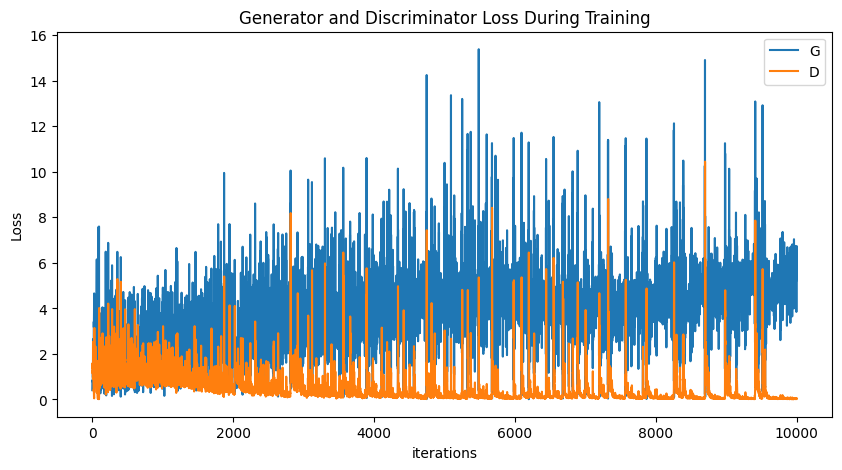

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses[:10000],label="G")
plt.plot(D_losses[:10000],label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
plt.rcParams['animation.embed_limit'] = 2560000000000  # Set to a higher value (in MB) if needed

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
anim = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
anim.save('plan.gif', dpi=160, writer='ffmpeg')

HTML(anim.to_jshtml())

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


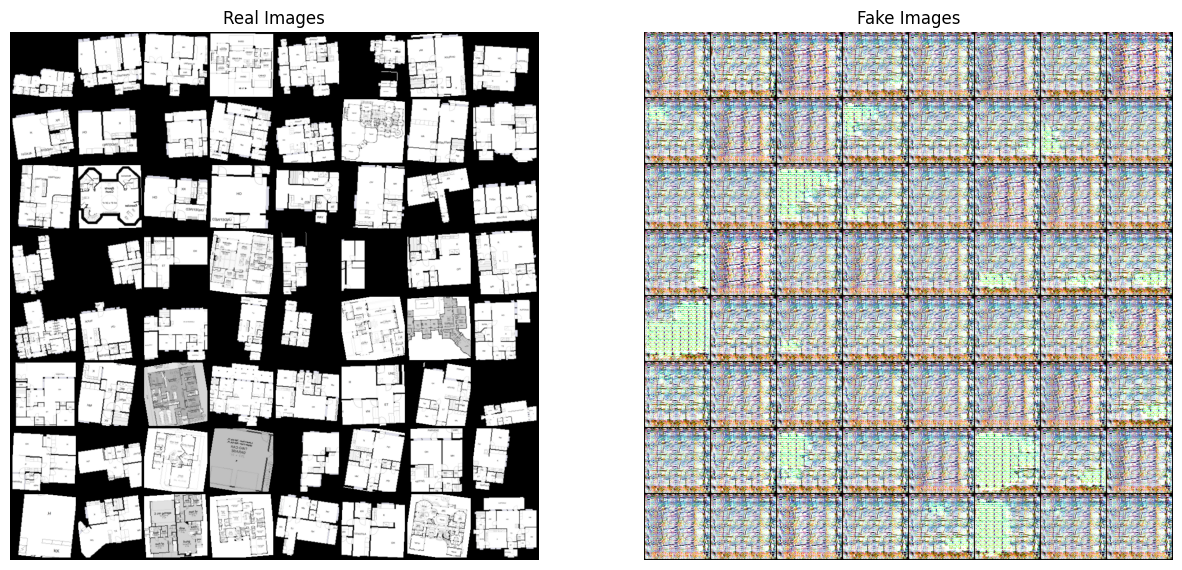

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [ ]:
# Plot evaluation metrics
def plot_metrics(is_scores, psnr_scores):
    epochs = range(len(is_scores))

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 4, 1)
    plt.plot(epochs, is_scores, label='Inception Score')
    plt.xlabel('Epoch')
    plt.ylabel('Inception Score')
    plt.title('Inception Score over Epochs')
    plt.legend()

    # plt.subplot(1, 4, 2)
    # plt.plot(epochs, fid_scores, label='FID Score')
    # plt.xlabel('Epoch')
    # plt.ylabel('FID Score')
    # plt.title('FID Score over Epochs')
    # plt.legend()

    # plt.subplot(1, 4, 3)
    # plt.plot(epochs, ssim_scores, label='SSIM Score')
    # plt.xlabel('Epoch')
    # plt.ylabel('SSIM Score')
    # plt.title('SSIM Score over Epochs')
    # plt.legend()

    plt.subplot(1, 4, 4)
    plt.plot(epochs, psnr_scores, label='PSNR Score')
    plt.xlabel('Epoch')
    plt.ylabel('PSNR Score')
    plt.title('PSNR Score over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Visualize evaluation metrics
plot_metrics(is_scores)


TypeError: plot_metrics() missing 1 required positional argument: 'psnr_scores'

In [ ]:
print(is_scores)

[(tensor(1.), tensor(0.)), (tensor(1.), tensor(0.)), (tensor(1.), tensor(0.)), (tensor(1.), tensor(0.)), (tensor(1.), tensor(0.)), (tensor(1.), tensor(0.)), (tensor(1.0000), tensor(2.0050e-05)), (tensor(1.0010), tensor(0.0006)), (tensor(1.0288), tensor(0.0269)), (tensor(1.0819), tensor(0.0457)), (tensor(1.4138), tensor(0.1166)), (tensor(1.4083), tensor(0.1239)), (tensor(1.5807), tensor(0.1049)), (tensor(1.6358), tensor(0.1357)), (tensor(1.8144), tensor(0.2067)), (tensor(1.8303), tensor(0.1718)), (tensor(1.8126), tensor(0.1703)), (tensor(1.7257), tensor(0.1498)), (tensor(1.9907), tensor(0.2432)), (tensor(1.7446), tensor(0.0851)), (tensor(1.9371), tensor(0.2315)), (tensor(1.8784), tensor(0.2187)), (tensor(2.0462), tensor(0.1972)), (tensor(1.9983), tensor(0.2865)), (tensor(1.9500), tensor(0.1514)), (tensor(1.8456), tensor(0.2236)), (tensor(2.1465), tensor(0.2837)), (tensor(1.9504), tensor(0.1688)), (tensor(2.2643), tensor(0.3195)), (tensor(2.1098), tensor(0.2301)), (tensor(2.2183), tensor

In [ ]:
epochs = range(len(is_scores))

plt.figure(figsize=(12, 5))

plt.subplot(1, 4, 1)
plt.plot(epochs[:80], is_scores[:80], label='Inception Score')
plt.xlabel('Epoch')
plt.ylabel('Inception Score')
plt.title('Inception Score over Epochs')
plt.legend()
plt.show()

NameError: name 'is_scores' is not defined

In [ ]:
print(psnr_scores)

[tensor(6.6667, grad_fn=<SqueezeBackward0>), tensor(6.4777, grad_fn=<SqueezeBackward0>), tensor(6.0998, grad_fn=<SqueezeBackward0>), tensor(6.0018, grad_fn=<SqueezeBackward0>), tensor(5.5570, grad_fn=<SqueezeBackward0>), tensor(5.1740, grad_fn=<SqueezeBackward0>), tensor(4.7814, grad_fn=<SqueezeBackward0>), tensor(4.6409, grad_fn=<SqueezeBackward0>), tensor(4.6035, grad_fn=<SqueezeBackward0>), tensor(4.0773, grad_fn=<SqueezeBackward0>), tensor(4.6097, grad_fn=<SqueezeBackward0>), tensor(4.2915, grad_fn=<SqueezeBackward0>), tensor(4.4330, grad_fn=<SqueezeBackward0>), tensor(4.6541, grad_fn=<SqueezeBackward0>), tensor(4.5717, grad_fn=<SqueezeBackward0>), tensor(4.7093, grad_fn=<SqueezeBackward0>), tensor(4.4878, grad_fn=<SqueezeBackward0>), tensor(4.6281, grad_fn=<SqueezeBackward0>), tensor(4.5375, grad_fn=<SqueezeBackward0>), tensor(4.5013, grad_fn=<SqueezeBackward0>), tensor(4.4068, grad_fn=<SqueezeBackward0>), tensor(4.1040, grad_fn=<SqueezeBackward0>), tensor(4.2675, grad_fn=<Squeeze

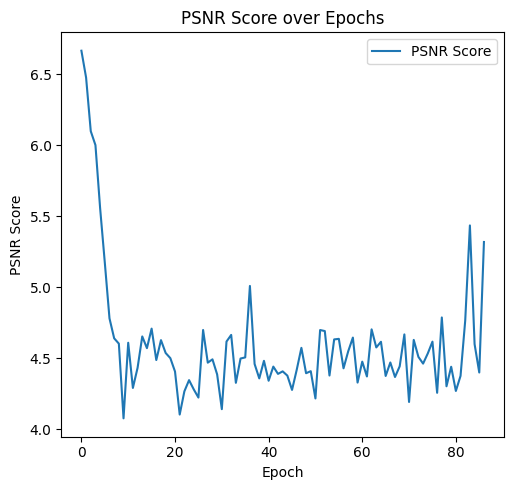

In [ ]:
epochs = range(len(psnr_scores))


psnr_tensor = torch.tensor(psnr_scores)
plt.figure(figsize=(20, 5))
plt.subplot(1, 4, 4)
plt.plot(epochs, psnr_tensor, label='PSNR Score')
plt.xlabel('Epoch')
plt.ylabel('PSNR Score')
plt.title('PSNR Score over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

Text(0, 0.5, 'Score')

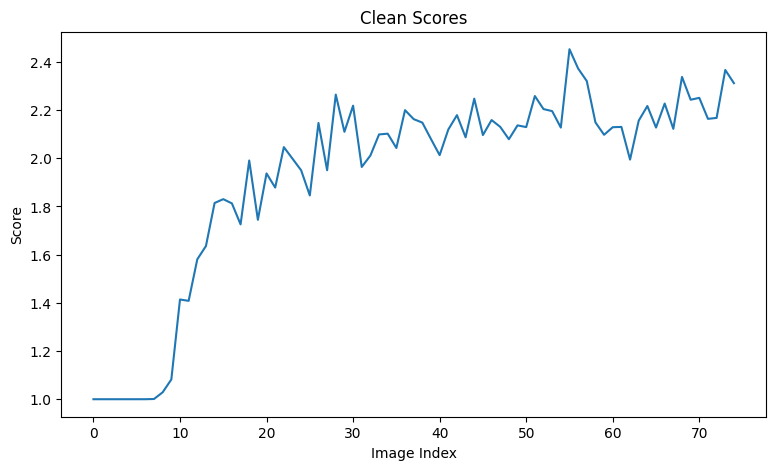

In [ ]:
# Separate clean and adversarial scores
clean_scores = [x[0] for x in is_scores[:75]]

# Plotting
plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.plot(clean_scores)
plt.title('Clean Scores')
plt.xlabel('Image Index')
plt.ylabel('Score')



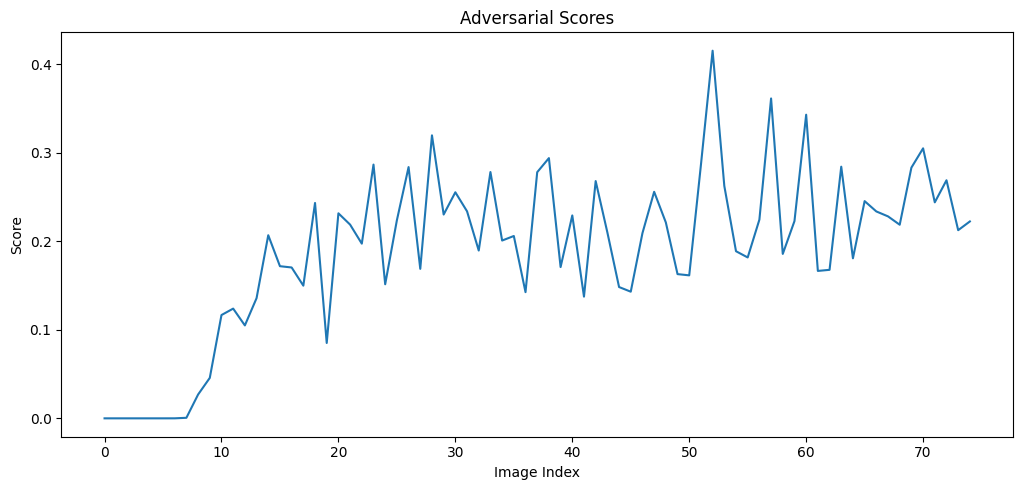

In [ ]:
adversarial_scores = [x[1] for x in is_scores[:75]]

plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 2)
plt.plot(adversarial_scores)
plt.title('Adversarial Scores')
plt.xlabel('Image Index')
plt.ylabel('Score')

plt.tight_layout()
plt.show()

In [ ]:
print(len(G_losses))

19034


In [ ]:
from tabulate import tabulate
epochs = list(range(1, len(G_losses[:10]) + 1))

# Combine all data into a list of lists
data = list(zip(epochs, G_losses[:10], D_losses[:10]))

# Print the table
table = tabulate(data, headers=["Epoch", "Generator Loss", "Discriminator Loss"], tablefmt="grid")
print(table)

+---------+------------------+----------------------+
|   Epoch |   Generator Loss |   Discriminator Loss |
+=========+==================+======================+
|       1 |         0.407857 |              1.38209 |
+---------+------------------+----------------------+
|       2 |         0.531976 |              1.58524 |
+---------+------------------+----------------------+
|       3 |         0.842069 |              1.39449 |
+---------+------------------+----------------------+
|       4 |         0.828624 |              1.19274 |
+---------+------------------+----------------------+
|       5 |         0.83339  |              1.14582 |
+---------+------------------+----------------------+
|       6 |         0.772823 |              1.19615 |
+---------+------------------+----------------------+
|       7 |         0.826202 |              1.25765 |
+---------+------------------+----------------------+
|       8 |         0.89408  |              1.29616 |
+---------+-----------------

In [ ]:
num_ep

In [ ]:
import matplotlib.pyplot as plt

iterations_per_epoch = 44

# Create epoch-wise loss lists
G_losses_epoch = []
D_losses_epoch = []

for i in range(0, len(G_losses), iterations_per_epoch):
    G_loss_epoch_avg = sum(G_losses[i:i+iterations_per_epoch]) / iterations_per_epoch
    D_loss_epoch_avg = sum(D_losses[i:i+iterations_per_epoch]) / iterations_per_epoch
    G_losses_epoch.append(G_loss_epoch_avg)
    D_losses_epoch.append(D_loss_epoch_avg)

# Calculate the number of epochs
num_epochs = len(G_losses_epoch)




TypeError: object of type 'ellipsis' has no len()

In [ ]:
# Plotting
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss Per Epoch")
plt.plot(range(1, num_epochs + 1), G_losses_epoch, label="G")  # Plot against epoch numbers
plt.plot(range(1, num_epochs + 1), D_losses_epoch, label="D")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# torch.save(netG.state_dict(), 'works.pth')

In [ ]:
# from google.colab import files

# # Download the saved model file
# files.download('works.pth')
# files.download('plan.gif')

In [ ]:
# torch.cuda.empty_cache()

In [ ]:
# print(torch.cuda.memory_summary(device=None, abbreviated=False))

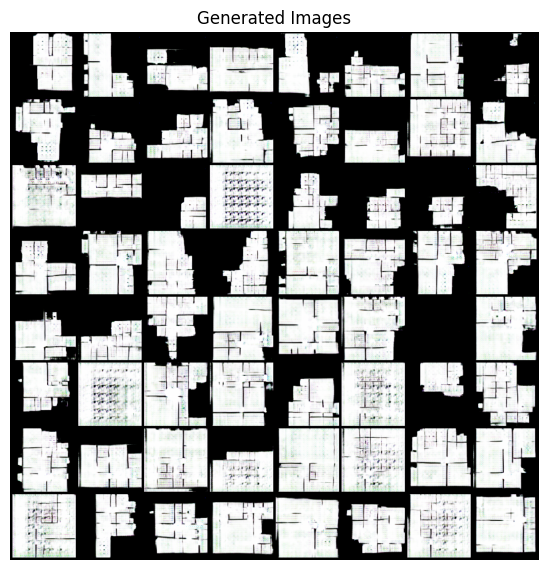

In [ ]:
# Load the generator model
ngpu = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.load('/content/drive/MyDrive/model_epoch_176.pth', map_location=device)
net = Generator(ngpu).to(device)
net.load_state_dict(model['generator'])

net.eval()

# Generate random noise
nz = 100  # Size of the latent z vector
num_images = 64  # Number of images to generate
noise = torch.randn(num_images, nz, 1, 1, device=device)

# Generate images
with torch.no_grad():
    generated_images = net(noise).detach().cpu()

# Display or save generated images
# vutils.save_image(generated_images, 'generated_images.png', normalize=True, nrow=8)
# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(vutils.make_grid(generated_images, padding=5, nrow=8, normalize=True)))
plt.show()


In [ ]:
# # Path to the folder containing saved models
# model_folder = "model"

# # Path to the folder where you want to save the generated images
# output_folder = "generated_images"

# # Device configuration
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Load the generator
# def load_generator(model_path):
#     # Load the model
#     checkpoint = torch.load(model_path, map_location=device)
#     gen = Generator(ngpu).to(device)
#     # Get the generator from the checkpoint
#     gen.load_state_dict(checkpoint['generator'])

#     # Evaluation mode
#     gen.eval()

#     return gen

# # Generate images
# def generate_images(gen, epoch, num_images=10, latent_dim=100, output_folder=output_folder):
#     # Create output folder if it doesn't exist
#     os.makedirs(output_folder, exist_ok=True)

#     # Generate random noise
#     noise = torch.randn(num_images, latent_dim, 1, 1, device=device)

#     # Generate fake images
#     with torch.no_grad():
#         fake_images = gen(noise).detach().cpu()

#     # Save the generated images
#     image_path = os.path.join(output_folder, f"epoch_{epoch}_generated_images.png")
#     vutils.save_image(fake_images, image_path, normalize=True)

# # Iterate over models in the folder
# for epoch_file in sorted(os.listdir(model_folder)):
#     if epoch_file.endswith(".pth"):
#         epoch = int(epoch_file.split("_")[2].split(".")[0])
#         model_path = os.path.join(model_folder, epoch_file)
#         gen = load_generator(model_path)
#         generate_images(gen, epoch)
